<h2>주제</h2>

기업의 성공 확률 예측 AI 알고리즘 개발</br>

기업의 다양한 데이터를 기반으로 기업의 성공 여부를 분류하는 AI 알고리즘을 개발해보세요!</br>

<h2>EDA</h2>

In [53]:
# %pip install pytorch-tabnet

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('./submission/sample_submission.csv')
print(train.isnull().sum())


ID                   0
설립연도                 0
국가                   0
분야                 857
투자단계                 0
직원 수               174
인수여부                 0
상장여부                 0
고객수(백만명)          1320
총 투자금(억원)            0
연매출(억원)              0
SNS 팔로워 수(백만명)       0
기업가치(백억원)         1220
성공확률                 0
dtype: int64


<h2>전처리</h2>

Baseline Code</br>
한번 실행을 해야 값이 다 수치값으로 바뀌게 된다.

In [54]:
#특성과 타겟 변수 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

# 설립연도 타입 변환 (int -> object)
train['설립연도'] =train['설립연도'].astype('object')
test['설립연도'] =test['설립연도'].astype('object')

category_features = ['설립연도','국가','분야','투자단계','기업가치(백억원)']
numeric_features = ['직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)']
bool_features = ['인수여부','상장여부']

# LabelEncoder 객체를 각 범주형 feature별로 따로 저장하여 사용
encoders = {}

# 범주형 데이터를 encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# 불리언 값을 0과 1로 변환 ('Yes' → 1, 'No' → 0 으로 변환)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# 수치형 변수 결측치를 평균값으로 대체
for feature in numeric_features:
    mean_value = train[feature].mean()
    train[feature] = train[feature].fillna(mean_value)
    test[feature] = test[feature].fillna(mean_value)

# TabNet용 범주형 변수 인덱스(cat_idxs) 및 차원(cat_dims) 설정
features = [col for col in train.columns if col != '성공확률']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

/var/folders/d4/sthv_klj36vblf3ghqbtf9br0000gn/T/ipykernel_1222/2865176146.py:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/d4/sthv_klj36vblf3ghqbtf9br0000gn/T/ipykernel_1222/2865176146.py:20: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [55]:
test.head()

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원)
0,1,9,9,4,3261.0,0,1,45.0,5021.0,6680.0,2.00,0
1,19,0,8,4,3707.0,1,0,70.0,1601.0,4654.0,4.20,5
2,13,5,6,0,236.0,1,1,89.0,4709.0,9289.0,1.00,4
3,2,0,5,1,637.0,1,1,17.0,2145.0,7005.0,5.00,0
4,5,9,9,1,4922.0,1,0,68.0,4995.0,7593.0,4.36,5


<h2>상관관계</h2>

다중공신성(multi-collinearity)를 확인할 수 있다

In [56]:
# 상관관계
import plotly.graph_objects as go

fig = go.Figure()
numeric_df = train.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr(method='pearson')

fig = go.Figure(
    data=go.Heatmap(
        z=corr.values,
        x=corr.columns,
        y=corr.columns,
        colorscale=[[0, 'blue'], [1, 'red']],
        text=corr.values.round(2),
        texttemplate="%{text}",
        textfont={"size":12}
    )
)

fig.update_layout(
    title='enterprise',
    xaxis_nticks=36
)

fig.show()

<h2>Linear Regression</h2>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# numeric_features = ['직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)']
fig, axs = plt.subplots(figsize=(16, 8), ncols=3, nrows=2)
numeric_features = ['직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)']
for i, feature in enumerate(numeric_features):
    row = i//3
    col = i%3
    # sns.regplot(x=feature, y='성공확률', data=train, ax=axs[row][col])

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = train['성공확률']
X_data = train.drop(['성공확률'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 0.056 , RMSE : 0.236
Variance score : -0.001


In [59]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 5))
print(train.columns)

절편 값: 0.5409537300225246
회귀 계수값: [-0.00029  0.00256 -0.00095  0.00173 -0.      -0.007    0.0134  -0.00031
 -0.      -0.       0.00054  0.00356]
Index(['설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)',
       '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률'],
      dtype='object')


In [60]:
coeff = pd.Series(data=np.round(lr.coef_, 5), index=X_data.columns)
coeff.sort_values(ascending=False)

상장여부              0.01340
기업가치(백억원)         0.00356
국가                0.00256
투자단계              0.00173
SNS 팔로워 수(백만명)    0.00054
직원 수             -0.00000
총 투자금(억원)        -0.00000
연매출(억원)          -0.00000
설립연도             -0.00029
고객수(백만명)         -0.00031
분야               -0.00095
인수여부             -0.00700
dtype: float64

In [61]:
intercept = lr.intercept_
coef = lr.coef_

y_pred = np.dot(test, coef) + intercept

In [62]:
sample_submission['성공확률'] = y_pred
sample_submission.to_csv('./submission/lr_submission.csv', index=False, encoding='utf-8-sig')

In [63]:
from sklearn.model_selection import cross_val_score

y_target = train['성공확률']
X_data = train.drop(['성공확률'], axis=1, inplace=False)
lr = LinearRegression()

neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 negative MSE scores:  [-0.06 -0.06 -0.06 -0.06 -0.06]
 5 folds 의 개별 RMSE scores :  [0.25 0.24 0.24 0.24 0.24]
 5 folds 의 평균 RMSE : 0.242


<h2>Regularized Linear Models - Ridge, Lasso</h2>

<h3>Rigde</h3>

L2 규제

In [64]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

y_target = train['성공확률']
X_data = train.drop(['성공확률'], axis=1, inplace=False)

ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-0.062 -0.058 -0.058 -0.058 -0.056]
 5 folds 의 개별 RMSE scores :  [0.248 0.242 0.242 0.242 0.236]
 5 folds 의 평균 RMSE : 0.242 


alpha값을 0, 0.1, 1, 10, 100 으로 변경하면서 RMSE 측정

In [65]:
alphas = [0, 0.1, 1, 10, 100, 1000, 10000]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)

    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.5f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 0.24177 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 0.24177 
alpha 1 일 때 5 folds 의 평균 RMSE : 0.24177 
alpha 10 일 때 5 folds 의 평균 RMSE : 0.24177 
alpha 100 일 때 5 folds 의 평균 RMSE : 0.24176 
alpha 1000 일 때 5 folds 의 평균 RMSE : 0.24173 
alpha 10000 일 때 5 folds 의 평균 RMSE : 0.24171 


각 alpha에 따른 회귀 계수 값을 시각화. 각 alpha값 별로 plt.subplots로 맷플롯립 축 생성

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 54036 (\N{HANGUL SYLLABLE PAL}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabto

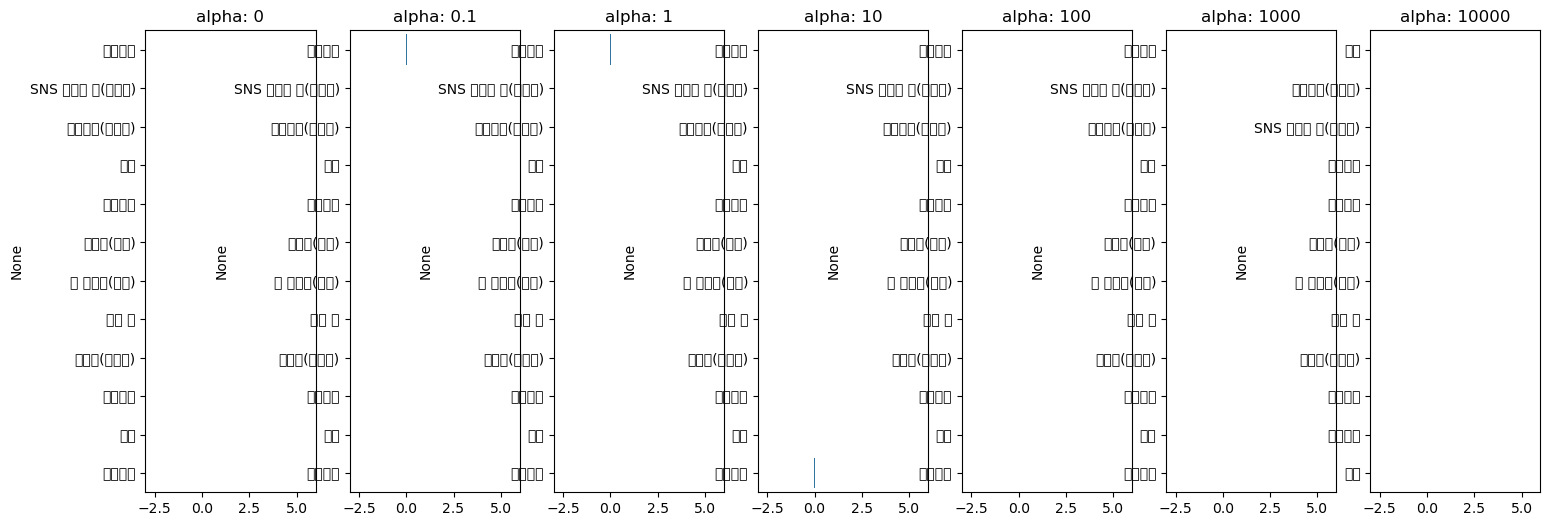

In [66]:
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=7)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)

    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha: '+str(alpha)
    coeff_df[colname] = coeff

    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

In [67]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100, 1000, 10000]
sort_column = 'alpha: '+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha: 0,alpha: 0.1,alpha: 1,alpha: 10,alpha: 100,alpha: 1000,alpha: 10000
상장여부,1.506306e-02,1.506169e-02,1.504932e-02,1.492671e-02,1.380229e-02,7.871881e-03,0.001484
SNS 팔로워 수(백만명),3.162488e-03,3.162456e-03,3.162167e-03,3.159281e-03,3.130437e-03,2.856715e-03,0.001487
기업가치(백억원),2.549955e-03,2.549946e-03,2.549860e-03,2.548994e-03,2.539802e-03,2.424901e-03,0.001581
국가,2.325132e-03,2.325127e-03,2.325078e-03,2.324593e-03,2.319711e-03,2.269942e-03,0.001854
설립연도,5.473436e-05,5.473285e-05,5.471932e-05,5.458525e-05,5.336354e-05,4.743929e-05,0.000048
연매출(억원),-9.009016e-07,-9.009095e-07,-9.009801e-07,-9.016803e-07,-9.081526e-07,-9.449137e-07,-0.000001
총 투자금(억원),-1.858336e-06,-1.858336e-06,-1.858336e-06,-1.858337e-06,-1.858362e-06,-1.858970e-06,-0.000002
직원 수,-2.099713e-06,-2.099711e-06,-2.099692e-06,-2.099500e-06,-2.097672e-06,-2.084605e-06,-0.000002
고객수(백만명),-1.281866e-04,-1.281870e-04,-1.281907e-04,-1.282280e-04,-1.285665e-04,-1.302099e-04,-0.000131
투자단계,-1.789989e-03,-1.789949e-03,-1.789590e-03,-1.786017e-03,-1.752049e-03,-1.511833e-03,-0.000719


In [68]:
test.head()

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원)
0,1,9,9,4,3261.0,0,1,45.0,5021.0,6680.0,2.00,0
1,19,0,8,4,3707.0,1,0,70.0,1601.0,4654.0,4.20,5
2,13,5,6,0,236.0,1,1,89.0,4709.0,9289.0,1.00,4
3,2,0,5,1,637.0,1,1,17.0,2145.0,7005.0,5.00,0
4,5,9,9,1,4922.0,1,0,68.0,4995.0,7593.0,4.36,5


In [69]:
y_pred = np.dot(test, coeff_df['alpha: 10000']) + ridge.intercept_
sample_submission['성공확률'] = y_pred

In [70]:
sample_submission.to_csv('./submission/ridge_subimssion.csv', index=False, encoding='utf-8-sig')

<h3>Lasso</h3>

In [80]:
from sklearn.linear_model import Lasso, ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score

y_target = train['성공확률']
X_data = train.drop(['성공확률'], axis=1, inplace=False)

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
    
    coeff_df = pd.DataFrame()
    if verbose : print("####### ", model_name, " ########")
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.2)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)

        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.5f}'.format(param, avg_rmse))

        model.fit(X_data_n, y_target_n)
        if return_coeff:
            coeff = pd.DataFrame(data=model.coef_, index=X_data_n.columns)
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df


In [72]:
Lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=Lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso  ########
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 3일 때 5 폴드 세트의 평균 RMSE: 0.242


In [73]:
sort_column = 'alpha:'+str(Lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
설립연도,0.000000,0.000000,0.000000,0.000000,0.000000e+00
국가,0.000000,0.000000,0.000000,0.000000,0.000000e+00
분야,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00
투자단계,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00
인수여부,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00
상장여부,0.000000,0.000000,0.000000,0.000000,0.000000e+00
고객수(백만명),-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00
SNS 팔로워 수(백만명),0.000000,0.000000,0.000000,0.000000,0.000000e+00
기업가치(백억원),0.000000,0.000000,0.000000,0.000000,0.000000e+00
연매출(억원),-0.000001,-0.000001,-0.000001,-0.000001,-9.803970e-07


In [74]:
model = Lasso(alpha=3)
model.fit(X_data, y_target)

y_pred = np.dot(test, model.coef_) + model.intercept_
sample_submission['성공확률'] = y_pred
sample_submission.to_csv('./submission/lasso_submission.csv', index=False, encoding='utf-8-sig')

<h2>엘라스틱넷</h2>

In [75]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet  ########
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.242
alpha 3일 때 5 폴드 세트의 평균 RMSE: 0.242


In [76]:
model = ElasticNetCV(
    l1_ratio=[0.07, 0.1, 0.3],   # L1 비율 후보들
    alphas=np.logspace(-3, 1, 10),       # alpha 값 후보들
    cv=5,                                # 5-fold 교차검증
    random_state=42
)
model.fit(X_data, y_target)

neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)

print(model.alpha_, model.l1_ratio_)
print(neg_mse_scores)

0.021544346900318832 0.07
[-0.06166631 -0.05835519 -0.05825843 -0.05849709 -0.05580735]


In [77]:
y_pred = np.dot(test, model.coef_) + model.intercept_
sample_submission['성공확률'] = y_pred
sample_submission.to_csv('./submission/ElasticNet.csv', index=False, encoding='utf-8-sig')

<h2>선형 회귀 모델을 위한 데이터 변환</h2>

In [78]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# standard:표준 정규 분포 변환, minmax:최대값/최소밗 정규화, log:로그변환
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data
    

In [81]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 10일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 100일 때 5 폴드 세트의 평균 RMSE: 0.24176

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 10일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 100일 때 5 폴드 세트의 평균 RMSE: 0.24175

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.24410
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.24410
alpha 10일 때 5 폴드 세트의 평균 RMSE: 0.24408
alpha 100일 때 5 폴드 세트의 평균 RMSE: 0.24391

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.24177
alpha 10일 때 5 폴드 세트의 평균 RMSE: 0.24175
alpha 100일 때 5 폴드 세트의 평균 RMSE: 0.24164

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.24407
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.24384
alpha 10일 때 5 폴드 세트의 평균 RMSE: 0.24286
alpha 100일 때 5 폴드 세트의 평균 RMSE: 0.24184

## 변환 유형:Log, Polynomial Degree:N

RMSE가 가장 작은 값을 기준으로 회귀계수/절편 값 추출</br>

변환 유형:MinMax, Polynomial Degree:None </br>
alpha 100일 때 5 폴드 세트의 평균 RMSE: 0.24164

In [85]:
model = Ridge(alpha=100)
X_input_data = MinMaxScaler().fit_transform(X_data)
model.fit(X_input_data, y_target)

y_pred = np.dot(test, model.coef_) + model.intercept_
sample_submission['성공확률'] = y_pred
sample_submission.to_csv('./submission/ridge_data_processing.csv', index=False, encoding='utf-8-sig')